In [36]:
import torch
import torch as th
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

from Modules import STFT, MVDR
from model import Unet_model
from data import my_dataset
from matplotlib import pyplot as plt
from loss import MultiResSpecLoss
from torchmetrics import ScaleInvariantSignalNoiseRatio

In [37]:
data_train = my_dataset('./beam_data/train')

fs = 16000  # Sampling frequency
window_length = int(0.025 * fs)  # 25 ms window length
window_shift = int(0.01 * fs)  # 10 ms window shift
stft = STFT(n_fft = window_length, hop=window_shift)

train_target, train_sample, train_noise = data_train[0]
spec_noise = stft.stft(train_noise[None])

In [38]:
def pipeline(model, spec):
    magn = spec.abs()
    phase = spec.angle()
    mask = model(torch.log(magn+1e-5))
    mag_predict = magn * mask
    z = torch.polar(mag_predict, phase)
#     imag = mag_predict * th.sin(phase)
#     real = mag_predict * th.cos(phase)
#     z = th.complex(real, imag)
    return z

In [39]:
torch.manual_seed(1)


crit = MultiResSpecLoss(factor=100,
            f_complex=100,
            gamma=0.3,
            n_ffts=[1024, window_length])

epochs = 1000
model = Unet_model()

optim = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optim, T_0=40
        )
si = ScaleInvariantSignalNoiseRatio()
losses = []
metrics = []

for epoch in tqdm(range(epochs)):
    optim.zero_grad()
    
    z = pipeline(model, spec_noise)
    wave_predict = stft.istft(z, train_sample.shape[-1])
    loss = crit(wave_predict, train_target[None]) + F.mse_loss(wave_predict, train_target[None])
    
    loss.backward()
    optim.step()
    
    metrics.append(si(wave_predict.detach(), train_target[None]))
    losses.append(loss.item())
    #print("Epoch [{}/{}], loss: {:.4f}, metric: {:.4f}".format(epoch+1, epochs, losses[-1], metrics[-1]))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:14<00:00,  3.93it/s]


min loss: 5.285921573638916


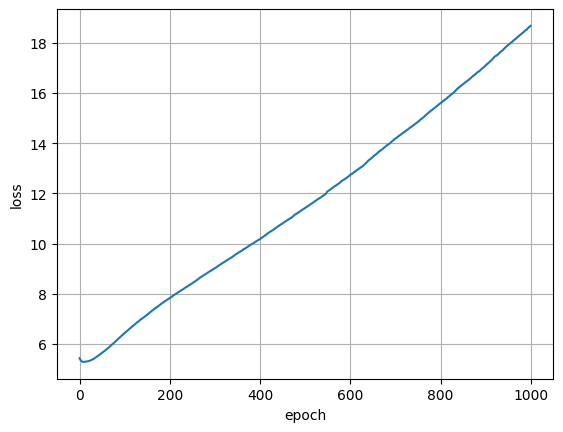

max metric: -0.03147593140602112


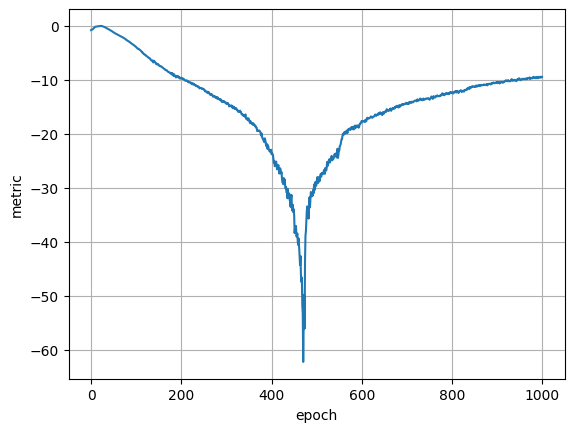

In [40]:
print(f'min loss: {min(losses)}')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.plot(losses);
plt.show()
print(f'max metric: {max(metrics)}')

plt.xlabel('epoch')
plt.ylabel('metric')
plt.grid()
plt.plot(metrics);